In [1]:
from robovast.common.analysis import read_output_files, read_output_csv, calculate_speeds_from_poses, print_bag_topics, for_each_test, get_behavior_info
import pandas as pd

DATA_DIR = '/home/fred/git/robovast/results/run-2026-02-11-203525/test-2/0'

try:
    df = read_output_files(DATA_DIR, lambda test_dir: read_output_csv(test_dir, "poses.csv"))
    df.loc[df['frame'] == 'turtlebot4_base_link_gt', 'position.x'] += 8

    # # for debugging
    # for_each_test(DATA_DIR, lambda test_dir: print_bag_topics(test_dir))
    # read complete rosbag
    # df_bag = read_output_files(DATA_DIR, lambda test_dir: read_output_csv(test_dir, "rosbag2.csv"))

    df_behaviors = read_output_files(DATA_DIR, lambda test_dir: read_output_csv(test_dir, "behaviors.csv"))
    df_behavior_info = get_behavior_info('differential_drive_robot.nav_to_pose', df_behaviors)
except Exception as e:
    print(f"Error reading rosbag files: {e}")
    raise SystemExit("No rosbag data found.")

## Overview

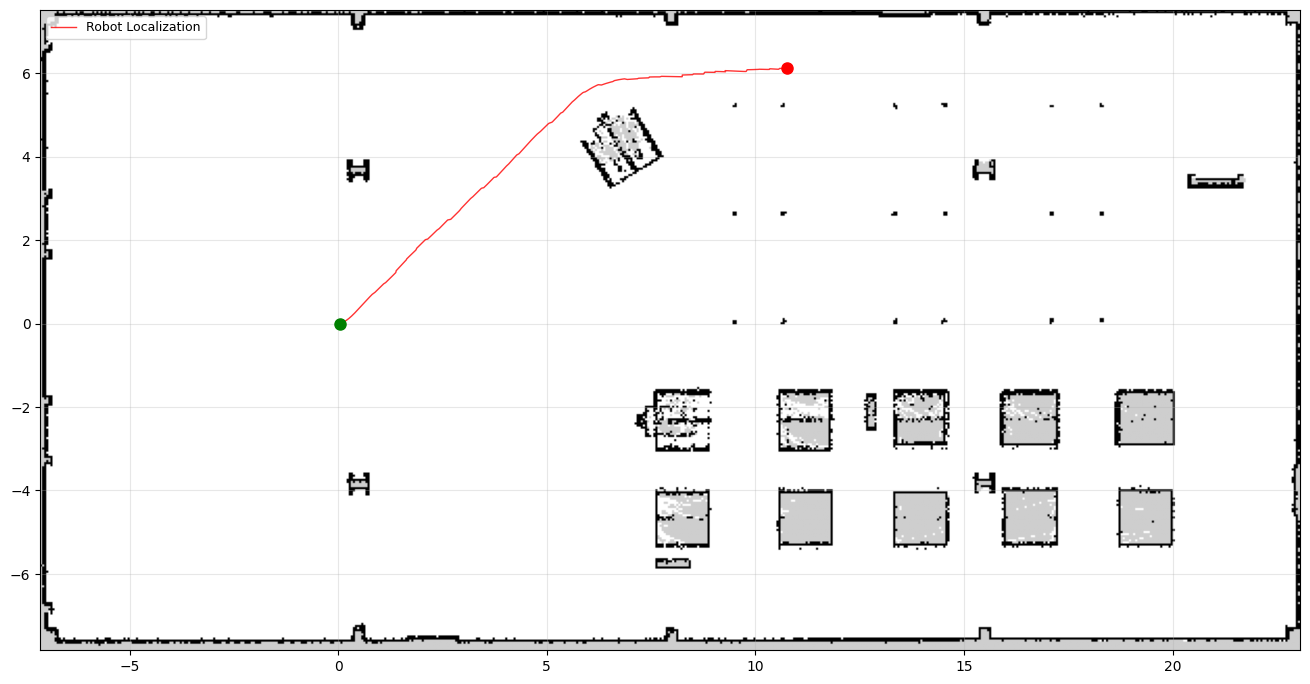

In [2]:
from robovast_nav.gui import MapVisualizer
viz = MapVisualizer()

# Cache filtered dataframes to avoid repeated filtering
df_robot_mask = df['frame'] == 'base_link'
df_gt_mask = df['frame'] == 'turtlebot4_base_link_gt'
path_robot = list(zip(df.loc[df_robot_mask, 'position.x'], df.loc[df_robot_mask, 'position.y']))
path_groundtruth = list(zip(df.loc[df_gt_mask, 'position.x'], df.loc[df_gt_mask, 'position.y']))

viz.load_map("/opt/ros/jazzy/share/nav2_bringup/maps/depot.yaml")
viz.create_figure(figsize=(14, 12))

_ = viz.draw_path(path_groundtruth, linewidth=1, color='blue', label='Ground Truth')
_ = viz.draw_path(path_robot, linewidth=1, color='red', label='Robot Localization')
_ = viz.ax.legend(loc='upper left', fontsize=9, ncol=2)

## Screen Capture

In [5]:
from IPython.display import HTML
from pathlib import Path
import os

# Display video capture
video_filename = 'capture.webm'
video_path = os.path.join(DATA_DIR, video_filename)

if os.path.exists(video_path):
    # Use HTML for full control over video width
    abs_path = os.path.abspath(video_path)
    file_url = Path(abs_path).as_uri()
    
    html = f'''<video controls loop autoplay muted style="width: 100%; max-width: 100%;">
        <source src="{file_url}" type="video/webm">
        Your browser does not support the video tag.
    </video>'''
    
    display(HTML(html))
else:
    print(f"Video not found at: {video_path}")